In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import copy
import time

In [3]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Current path
#path = '/content/drive/MyDrive/Colab Notebooks/Work/Reactors/Pseudomonas Reactor/'
path = ''

## Import Bioreactors data

In [5]:
RSEED = 42
np.random.seed(RSEED)
torch.manual_seed(RSEED)

In [6]:
# Load bioreactor data
full_sheet = pd.ExcelFile(path + 'BioreactorPsdmData.xlsx')
df_adip7d  = pd.read_excel(full_sheet, 'bioreactors 7d')
df_lostbio7d  = pd.read_excel(full_sheet, 'lost biomass 7d')

# Group the dataframe by 'reactor'
reactor_dfs = {name: group.reset_index(drop=True) for name, group in df_adip7d.groupby('reactor')}

# Get list of reactor keys and shuffle
reactor_keys = list(reactor_dfs.keys())
random.shuffle(reactor_keys)

for key in reactor_keys:
    reactor_dfs[key] = reactor_dfs[key].sample(frac=1).reset_index(drop=True)

In [7]:
df_adip7d

,reactor,media,glucose,flow_rate_microL,flow_rate,cychl,time,adipic_acid,out_biomass,out_biomas_dg
0,Reactor_1,0.25,2,195,0.195,10,1,0.000000,28.872288,0.288723
1,Reactor_1,0.25,2,195,0.195,10,2,0.093127,35.369568,0.353696
2,Reactor_1,0.25,2,195,0.195,10,3,0.205484,24.178003,0.241780
3,Reactor_1,0.25,2,195,0.195,10,4,0.189075,28.612397,0.286124
4,Reactor_1,0.25,2,195,0.195,10,5,0.169618,28.295654,0.282957
...,...,...,...,...,...,...,...,...,...,...
123,Reactor_16,1.00,2,105,0.105,50,4,0.000000,0.974592,0.009746
124,Reactor_16,1.00,2,105,0.105,50,5,0.000000,1.827360,0.018274
125,Reactor_16,1.00,2,105,0.105,50,6,0.000000,1.595894,0.015959
126,Reactor_16,1.00,2,105,0.105,50,7,0.000000,1.815178,0.018152


## Classes and functions definitions

In [8]:
class ReactorRNN(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim, output_dim, num_layers=1):
        '''
        input_dim:      Number of input data at each timestep (the output of the previous timestep?)
        cond_dim:       Number of working conditions of the reactor
        hidden_dim:     Number of components of the hidden state
        output_dim:     Number of values to predict at each timestep
        num_layers:     Number of hidden layers
        '''
        super(ReactorRNN, self).__init__()
        
        # Number of LSTM layers
        self.num_layers = num_layers
        
        # FC layers mapping running conditions to initial hidden state
        self.condition_fc = nn.Linear(cond_dim, hidden_dim)

        # RNN
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # Map hidden state to outputs
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, cond, initial_input, seq_len):
       '''
       cond:              (batch, cond_dim)
       initial_input:     (batch, 1, input_dim)
       seq_len:           total length to generate
       '''

       batch = cond.size(0)

       # Initial hidden state from working conditions
       h_0 = torch.tanh(self.condition_fc(cond))   # (batch_size, hidden_size)
       h_0 = h_0.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
       c_0 = torch.zeros_like(h_0)

       inputs = initial_input
       outputs = []

       for _ in range(seq_len):
          out, (h_0, c_0) = self.rnn(inputs, (h_0, c_0))
          y = self.fc_out(out[:, -1:, :]) # Last time step
          outputs.append(y)
          inputs = y

       return torch.cat(outputs, dim = 1) # (batch, seq_len, output_dim)
        
class ReactorDataset(Dataset):
  '''
  Creates a Dataset where each element corresponds to a different bioreactor time series
  '''
  def __init__(self, df, input_cols, output_cols, shuffle_within=True, convert_to_tensors = False):
    # Group data by reactor
    self.reactor_dfs = {name: group.reset_index(drop=True) for name, group in df.groupby('reactor')}

    # Store input/output column names
    self.input_cols = input_cols
    self.output_cols = output_cols
    self.shuffle_within = shuffle_within
    self.convert_to_tensors = convert_to_tensors

    # List of reactor names (shuffled)
    self.reactor_keys = list(self.reactor_dfs.keys())
    random.shuffle(self.reactor_keys)

    # Shuffle each reator data if shuffle_within = True
    if self.shuffle_within:
      for key in self.reactor_keys:
        self.reactor_dfs[key] = self.reactor_dfs[key].sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return len(self.reactor_keys)


  def __getitem__(self, idx):
    # Get reactor name by index
    reactor_name = self.reactor_keys[idx]
    df_reactor = self.reactor_dfs[reactor_name]

    # Get input/output as numpy arrays
    X = df_reactor[self.input_cols].values.astype(np.float32)
    y = df_reactor[self.output_cols].values.astype(np.float32)

    if self.convert_to_tensors:
      X = torch.tensor(X)
      y = torch.tensor(y)

    return X, y, reactor_name

class ReactorSequenceDataset(Dataset):
    '''

    '''
    def __init__(self, df, input_cols, output_cols):
        self.reactor_dfs = {
            name: group.reset_index(drop=True)
            for name, group in df.groupby("reactor")
        }
        self.reactor_keys = list(self.reactor_dfs.keys())
        self.input_cols = input_cols
        self.output_cols = output_cols

    def __len__(self):
        return len(self.reactor_keys)

    def __getitem__(self, idx):
        key = self.reactor_keys[idx]
        df = self.reactor_dfs[key]

        X_static = df[self.input_cols].iloc[0].values.astype(np.float32)
        y_seq = df[self.output_cols].values.astype(np.float32)

        return torch.tensor(X_static), torch.tensor(y_seq)
      
def train_RNN(dataloader, model, loss_fn, optimizer):
    model.train()
    losses_over_batches = []

    for X_static, y_seq in dataloader:
        # X_static shape: (batch, cond_dim)
        # y_seq shape:    (batch, T, out_dim)
        
        batch_size, seq_length, out_dim = y_seq.shape

        # Initial input
        initial_input = y_seq[:,0,:].unsqueeze(1) 

        # Fordward pass
        y_pred = model(cond=X_static, initial_input=initial_input, seq_len=seq_length)

        # Compute loss
        loss = loss_fn(y_pred, y_seq)
        losses_over_batches.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Compute average train loss
    avg_train_loss = np.mean(losses_over_batches)

    return avg_train_loss

def validate_RNN(dataloader, model, loss_fn):
    model.eval()
    batch_val_loss = []

    with torch.no_grad():
      for X_static, y_seq in dataloader:
        # X_static shape: (batch, cond_dim)
        # y_seq shape:    (batch, T, out_dim)

        batch_size, seq_length, out_dim = y_seq.shape

        initial_input = y_seq[:,0,:].unsqueeze(1) 

        # Predict
        y_pred = model(cond=X_static, initial_input=initial_input, seq_len=seq_length)

        # Compute loss
        loss = loss_fn(y_pred, y_seq)
        batch_val_loss.append(loss.item())

    # Compute average validation loss
    avg_val_loss = np.mean(batch_val_loss)

    return avg_val_loss

## Basic training and practice cells

In [9]:
# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [10]:
# Crop strings
input_columns = ['media', 'glucose', 'flow_rate', 'cychl']
output_columns = ['adipic_acid', 'out_biomas_dg']

In [146]:
# Define training and validation datasets
seq_dataset = ReactorSequenceDataset(df_adip7d, input_columns, output_columns)
loader  = DataLoader(seq_dataset, batch_size=1, shuffle=True)

num_reactors = len(seq_dataset)

# Define split
val_ratio = 0.15
val_size = int(num_reactors * val_ratio)
train_size = num_reactors - val_size
print(f"Training with {train_size} reactors and validating with {val_size} reactors")

# Split dataset
train_dataset, val_dataset = torch.utils.data.random_split(seq_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training with 14 reactors and validating with 2 reactors


In [147]:
m = ReactorRNN(input_dim=2, cond_dim=3, hidden_dim=4, output_dim=8, num_layers=3)
print(m)

ReactorRNN(
  (condition_fc): Linear(in_features=3, out_features=4, bias=True)
  (rnn): LSTM(2, 4, num_layers=3, batch_first=True)
  (fc_out): Linear(in_features=4, out_features=8, bias=True)
)


In [152]:
# Setting hyperparameters
input_dim   = next(iter(loader))[1].shape[2]
cond_dim    = next(iter(loader))[0].shape[1]
hidden_dim  = 2
output_dim  = next(iter(loader))[1].shape[2]
num_layers  = 1
lr = 1e-3
epochs = 1500

# Build model
reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dim, output_dim, num_layers)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

# Train and validate
total_train_losses = []
total_val_losses   = []

for epoch in range(epochs):

  # Train the model
  avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

  # Validate the model
  avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

  # Save losses values
  total_train_losses.append(avg_train_loss)
  total_val_losses.append(avg_val_loss)

  if epoch % 500 == 0:
    print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_val_losses[-1]:.4f}')
    print('-------------------------------------')

Epoch [1/1500]
Train Loss: 0.3952, Val Loss: 0.1829
-------------------------------------
Epoch [501/1500]
Train Loss: 0.0809, Val Loss: 0.0585
-------------------------------------
Epoch [1001/1500]
Train Loss: 0.0618, Val Loss: 0.0893
-------------------------------------


Hidden dimention: 4
Learning rate: 0.001
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


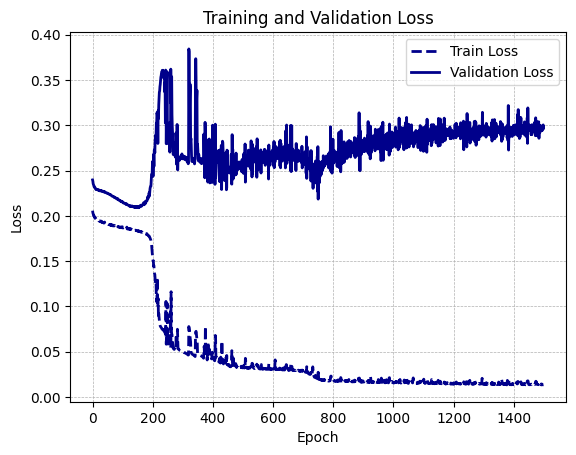

In [141]:
# Printing architectures details
print(f"Hidden dimention: {hidden_dim}")
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")

# Average score/error computed from the

plt.plot(total_train_losses, lw=2, c='darkblue', label='Train Loss', linestyle='--')
plt.plot(total_val_losses, lw=2, c='darkblue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Hyperparameter tunning

### Batch size and learning rate

Here I will perform some level hyperparameter tunning, first i want to know if it is better to use a batch size of 1 or 2 and also which learning rate value is suitable

In [165]:
# k-fold split
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)

# Setting hyperparameters
input_dim   = next(iter(loader))[1].shape[2]
cond_dim    = next(iter(loader))[0].shape[1]
k_folds = 8
hidden_dim  = 2
output_dim  = next(iter(loader))[1].shape[2]
num_layers  = 1
epochs = 1000

l_rates = [1e-1, 1e-2, 1e-3]
batch_sizes = [1, 2]

# For the grid search heatmap
A_heatmap_avg = np.zeros((len(batch_sizes), len(l_rates)))
A_heatmap_std = np.zeros((len(batch_sizes), len(l_rates)))


for i in range(len(batch_sizes)):
  for j in range(len(l_rates)):
    # For saving final validation loss of each fold
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
      print(f"----------- Fold {fold+1}/{k_folds}, Batch size {batch_sizes[i]}, Learning rate {l_rates[j]} -----------")

      # Subset datasets
      train_subset = torch.utils.data.Subset(seq_dataset, train_idx)
      val_subset   = torch.utils.data.Subset(seq_dataset, val_idx)

      # Dataloaders
      train_loader = DataLoader(train_subset, batch_size=batch_sizes[i], shuffle=True)
      val_loader   = DataLoader(val_subset, batch_size=batch_sizes[i], shuffle=False)
        
      # Build model
      reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dim, output_dim, num_layers)

      # Loss and optimizer
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(reactor_model.parameters(), lr=l_rates[j])

      # Save best model and model performance
      best_val_loss = float('inf')
      best_model_state = None
      best_paremeters = None

      for epoch in range(epochs):

        # Train the model
        avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

        # Validate the model
        avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

        if epoch % 500 == 0:
          print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
          print(f'Valid Loss: {avg_val_loss:.4f}\n')
      
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(reactor_model.state_dict())
        best_paremeters = [batch_sizes[i], l_rates[j]]

      # Save fold performance over validation set
      fold_results.append(avg_val_loss)

    # Compute full CV results and save to the heatmap matrix
    A_heatmap_avg[i,j] = np.mean(fold_results)
    A_heatmap_std[i,j] = np.std(fold_results)


    print(f'Cross validation results (Batch Size, Learning Rate) = ({batch_sizes[i],l_rates[j]})')
    print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold 1/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.3263
Valid Loss: 0.1711

Epoch [501/1000]
Train Loss: 0.2197
Valid Loss: 0.1547

----------- Fold 2/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.3869
Valid Loss: 0.2570

Epoch [501/1000]
Train Loss: 0.2131
Valid Loss: 0.1561

----------- Fold 3/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.2043
Valid Loss: 0.2739

Epoch [501/1000]
Train Loss: 0.1772
Valid Loss: 0.2651

----------- Fold 4/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.2747
Valid Loss: 0.2761

Epoch [501/1000]
Train Loss: 0.2048
Valid Loss: 0.2254

----------- Fold 5/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.2422
Valid Loss: 0.4915

Epoch [501/1000]
Train Loss: 0.1858
Valid Loss: 0.4659

----------- Fold 6/8, Batch size 1, Learning rate 0.1 -----------
Epoch [1/1000]
Train Loss: 0.3415
Valid Loss: 0.1607



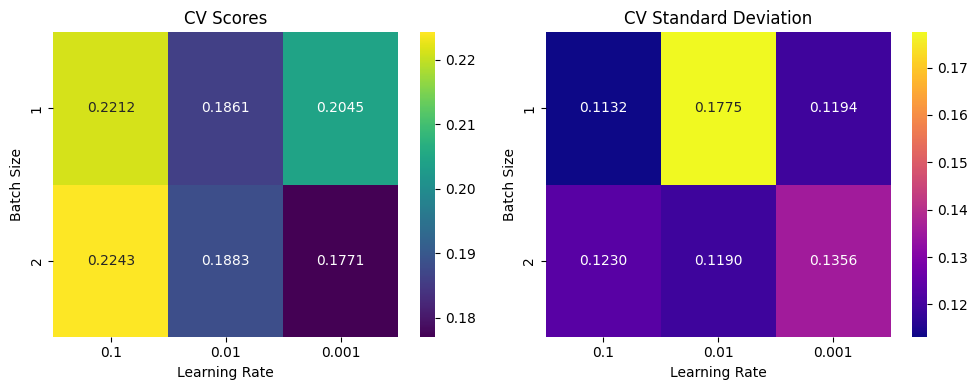

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", xticklabels=l_rates, yticklabels=batch_sizes, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_ylabel("Batch Size")
axes[0].set_xlabel("Learning Rate")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", xticklabels=l_rates, yticklabels=batch_sizes, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_ylabel("Batch Size")
axes[1].set_xlabel("Learning Rate")

plt.tight_layout()
plt.show()

The grid search yields a better CV result for `batch_size=2` and `lr=1e-2`. We balance between how low is the CV result but also the standard deviation

### Hidden dimention and LSTM layers

In [170]:
# k-fold split
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)

# Setting hyperparameters
input_dim   = next(iter(loader))[1].shape[2]
cond_dim    = next(iter(loader))[0].shape[1]
k_folds = 8
output_dim  = next(iter(loader))[1].shape[2]
epochs = 1000
batch_size = 2
lr = 1e-2

num_layers  = [1, 2]
hidden_dims  = [2, 4, 8]

# For the grid search heatmap
A_heatmap_avg = np.zeros((len(hidden_dims), len(num_layers)))
A_heatmap_std = np.zeros((len(hidden_dims), len(num_layers)))


for i in range(len(hidden_dims)):
  for j in range(len(num_layers)):
    # For saving final validation loss of each fold
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
      print(f"----------- Fold {fold+1}/{k_folds}, Hidden dim {hidden_dims[i]}, Learning rate {num_layers[j]} -----------")

      # Subset datasets
      train_subset = torch.utils.data.Subset(seq_dataset, train_idx)
      val_subset   = torch.utils.data.Subset(seq_dataset, val_idx)

      # Dataloaders
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
      val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
      # Build model
      reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dims[i], output_dim, num_layers[j])

      # Loss and optimizer
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

      # Save best model and model performance
      best_val_loss = float('inf')
      best_model_state = None
      best_paremeters = None

      for epoch in range(epochs):

        # Train the model
        avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

        # Validate the model
        avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

        if epoch % 500 == 0:
          print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
          print(f'Valid Loss: {avg_val_loss:.4f}\n')
      
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(reactor_model.state_dict())
        best_paremeters = [hidden_dims[i], num_layers[j]]

      # Save fold performance over validation set
      fold_results.append(avg_val_loss)

    # Compute full CV results and save to the heatmap matrix
    A_heatmap_avg[i,j] = np.mean(fold_results)
    A_heatmap_std[i,j] = np.std(fold_results)


    print(f'Cross validation results (Batch Size, Learning Rate) = ({hidden_dims[i]},{num_layers[j]})')
    print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold 1/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.2298
Valid Loss: 0.1784

Epoch [501/1000]
Train Loss: 0.1820
Valid Loss: 0.1157

----------- Fold 2/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.3286
Valid Loss: 0.2521

Epoch [501/1000]
Train Loss: 0.1768
Valid Loss: 0.2102

----------- Fold 3/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.9142
Valid Loss: 1.1066

Epoch [501/1000]
Train Loss: 0.0450
Valid Loss: 0.0503

----------- Fold 4/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.3441
Valid Loss: 0.4288

Epoch [501/1000]
Train Loss: 0.1746
Valid Loss: 0.2297

----------- Fold 5/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.3132
Valid Loss: 0.5169

Epoch [501/1000]
Train Loss: 0.0353
Valid Loss: 0.2386

----------- Fold 6/8, Hidden dim 2, Learning rate 1 -----------
Epoch [1/1000]
Train Loss: 0.2931
Valid Loss: 0.0583

Epoch [501/1

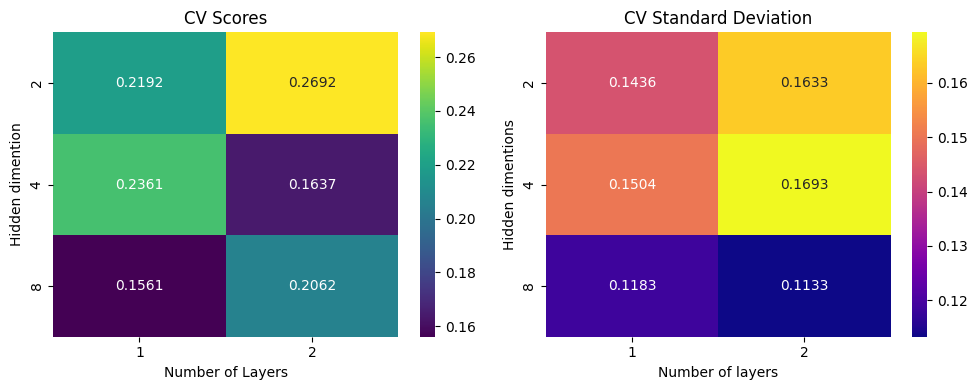

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", xticklabels=num_layers, yticklabels=hidden_dims, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_ylabel("Hidden dimention")
axes[0].set_xlabel("Number of Layers")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", xticklabels=num_layers, yticklabels=hidden_dims, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_ylabel("Hidden dimentions")
axes[1].set_xlabel("Number of layers")

plt.tight_layout()
plt.show()

We observer a slight tendency of decrease in the CV with the dimention of the hidden state. We choose `hidden_dim=8` and `num_layers=1` to give an accurate value for the CV score

With this choice, the optimized value of the CV score is:

$$\mathbf{CV}_{score} = 0.1561 \pm 0.1183$$

### Some additional testing

In [177]:
# k-fold split
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)

# Setting hyperparameters
input_dim   = next(iter(loader))[1].shape[2]
cond_dim    = next(iter(loader))[0].shape[1]
k_folds = 8
output_dim  = next(iter(loader))[1].shape[2]
epochs = 1000
batch_size = 2
lr = 1e-2

num_layers  = [1]
hidden_dims  = [8, 16, 32]

# For the grid search heatmap
A_heatmap_avg = np.zeros((len(hidden_dims), len(num_layers)))
A_heatmap_std = np.zeros((len(hidden_dims), len(num_layers)))


for i in range(len(hidden_dims)):
  for j in range(len(num_layers)):
    # For saving final validation loss of each fold
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
      print(f"----------- Fold {fold+1}/{k_folds}, Hidden dim {hidden_dims[i]}, Layers {num_layers[j]} -----------")

      # Subset datasets
      train_subset = torch.utils.data.Subset(seq_dataset, train_idx)
      val_subset   = torch.utils.data.Subset(seq_dataset, val_idx)

      # Dataloaders
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
      val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
      # Build model
      reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dims[i], output_dim, num_layers[j])

      # Loss and optimizer
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

      # Save best model and model performance
      best_val_loss = float('inf')
      best_model_state = None
      best_paremeters = None

      for epoch in range(epochs):

        # Train the model
        avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

        # Validate the model
        avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

        if epoch % 500 == 0:
          print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
          print(f'Valid Loss: {avg_val_loss:.4f}\n')
      
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(reactor_model.state_dict())
        best_paremeters = [hidden_dims[i], num_layers[j]]

      # Save fold performance over validation set
      fold_results.append(avg_val_loss)

    # Compute full CV results and save to the heatmap matrix
    A_heatmap_avg[i,j] = np.mean(fold_results)
    A_heatmap_std[i,j] = np.std(fold_results)


    print(f'Cross validation results (Batch Size, Learning Rate) = ({hidden_dims[i]},{num_layers[j]})')
    print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold 1/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.3486
Valid Loss: 0.2594

Epoch [501/1000]
Train Loss: 0.0095
Valid Loss: 0.0416

----------- Fold 2/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.4064
Valid Loss: 0.0985

Epoch [501/1000]
Train Loss: 0.0221
Valid Loss: 0.0731

----------- Fold 3/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.3742
Valid Loss: 0.4503

Epoch [501/1000]
Train Loss: 0.0120
Valid Loss: 0.0519

----------- Fold 4/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.3572
Valid Loss: 0.4148

Epoch [501/1000]
Train Loss: 0.0067
Valid Loss: 0.1828

----------- Fold 5/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.2077
Valid Loss: 0.6802

Epoch [501/1000]
Train Loss: 0.0080
Valid Loss: 0.3009

----------- Fold 6/8, Hidden dim 8, Layers 1 -----------
Epoch [1/1000]
Train Loss: 0.2643
Valid Loss: 0.0686

Epoch [501/1000]
Train Loss: 0.0139
Valid Loss: 0.0250

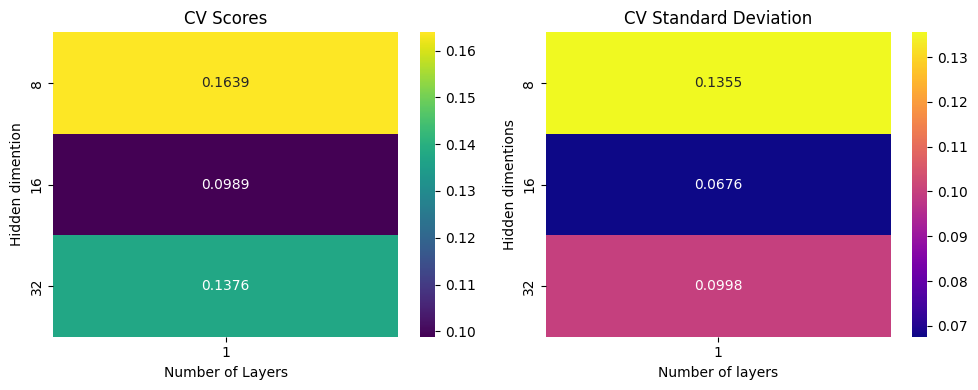

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", xticklabels=num_layers, yticklabels=hidden_dims, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_ylabel("Hidden dimention")
axes[0].set_xlabel("Number of Layers")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", xticklabels=num_layers, yticklabels=hidden_dims, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_ylabel("Hidden dimentions")
axes[1].set_xlabel("Number of layers")

plt.tight_layout()
plt.show()

The best performing model is actually the one with `hidden_dim=16` and only 1 layer. For this case the CV score is:

$$\mathbf{CV}_{score} = 0.0989 \pm 0.0676$$

## CV Score of the fine tuned model

In [17]:
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) 

# Training of the fine tuned model
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
fold_scores = []

# Setting hyperparameters
input_dim   = next(iter(train_loader))[1].shape[2]
cond_dim    = next(iter(train_loader))[0].shape[1]
hidden_dim  = 16
output_dim  = next(iter(train_loader))[1].shape[2]
num_layers  = 1
lr = 1e-3
epochs = 1500

for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
    print('Train-Valid reactor split:')
    print(train_reactor_idx)
    print(val_reactor_idx)

    # Randomly choose the reactors for training and validating
    train_reactors = unique_reactor_labels[train_reactor_idx]
    val_reactors   = unique_reactor_labels[val_reactor_idx]

    # Masks for spliting the reactors
    train_mask = np.isin(reactor_labels, train_reactors)
    val_mask   = np.isin(reactor_labels, val_reactors)

    # Split reactors into train-validation
    train_df = df_adip7d[train_mask]
    val_df = df_adip7d[val_mask]

    # DataSets
    train_dataset = ReactorSequenceDataset(train_df, input_columns, output_columns)
    val_dataset   = ReactorSequenceDataset(val_df, input_columns, output_columns)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Build fine tuned model
    reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dim, output_dim, num_layers)

    # Loss and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

    for epoch in range(epochs):

        # Train the model
        avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

        # Validate the model
        avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

        if epoch % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print('-------------------------------------')
    fold_scores.append(avg_val_loss)

print(f"Mean MSE: {np.mean(fold_scores)}")
print(f"MSE StanDev: {np.std(fold_scores)}")

Train-Valid reactor split:
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1]
Epoch [1/1500]
Train Loss: 0.2720, Val Loss: 0.2368
-------------------------------------
Epoch [501/1500]
Train Loss: 0.0134, Val Loss: 0.0578
-------------------------------------
Epoch [1001/1500]
Train Loss: 0.0057, Val Loss: 0.0724
-------------------------------------
Train-Valid reactor split:
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 15]
[ 5 14]
Epoch [1/1500]
Train Loss: 0.3009, Val Loss: 0.1131
-------------------------------------
Epoch [501/1500]
Train Loss: 0.0162, Val Loss: 0.0489
-------------------------------------
Epoch [1001/1500]
Train Loss: 0.0068, Val Loss: 0.0243
-------------------------------------
Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7  8  9 10 12 14 15]
[11 13]
Epoch [1/1500]
Train Loss: 0.4203, Val Loss: 0.5826
-------------------------------------
Epoch [501/1500]
Train Loss: 0.0162, Val Loss: 0.0413
-------------------------------------
Epoch [1001/1500]
Train Loss: 0.0

## Plot Adipic Acid prediction

Using the fine-tuned values of the hyperparameters, select a signle train-validation split and visualize the performanc eof adipic acid over time.

In [11]:
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) 
train_reactors, val_reactors = train_test_split(unique_reactor_labels, test_size=0.1, random_state=RSEED-1)

# Masks for spliting the reactors
train_mask = np.isin(reactor_labels, train_reactors)
val_mask   = np.isin(reactor_labels, val_reactors)

# Split reactors into train-validation
train_df = df_adip7d[train_mask]
val_df = df_adip7d[val_mask]

# DataSets
train_dataset = ReactorSequenceDataset(train_df, input_columns, output_columns)
val_dataset   = ReactorSequenceDataset(val_df, input_columns, output_columns)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Setting hyperparameters
input_dim   = next(iter(train_loader))[1].shape[2]
cond_dim    = next(iter(train_loader))[0].shape[1]
hidden_dim  = 16
output_dim  = next(iter(train_loader))[1].shape[2]
num_layers  = 1
lr = 1e-3
epochs = 1500

# Build fine tuned model
reactor_model = ReactorRNN(input_dim, cond_dim, hidden_dim, output_dim, num_layers)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

# Train and validate
total_train_losses = []
total_val_losses   = []

start_time = time.time()
for epoch in range(epochs):

  # Train the model
  avg_train_loss = train_RNN(train_loader, reactor_model, loss_function, optimizer)

  # Validate the model
  avg_val_loss = validate_RNN(val_loader, reactor_model, loss_function)

  # Save losses values
  total_train_losses.append(avg_train_loss)
  total_val_losses.append(avg_val_loss)

  if epoch % 500 == 0:
    print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_val_losses[-1]:.4f}')
    print('-------------------------------------')

training_time = time.time() - start_time
print(f"Total training time: {training_time} seconds")

Epoch [1/1500]
Train Loss: 0.4551, Val Loss: 0.8100
-------------------------------------
Epoch [501/1500]
Train Loss: 0.0131, Val Loss: 0.3590
-------------------------------------
Epoch [1001/1500]
Train Loss: 0.0054, Val Loss: 0.2794
-------------------------------------
Total training time: 48.076329708099365 seconds


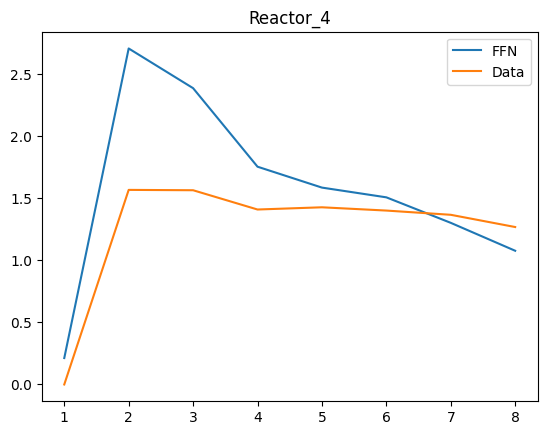

In [134]:
# Predict
i=0
y_pred = reactor_model(cond = val_dataset[0][0].unsqueeze(0), initial_input = val_dataset[0][1][0,:].unsqueeze(0).unsqueeze(0), seq_len = val_dataset[0][1].shape[0]).detach().cpu().numpy().squeeze(0)
t = np.linspace(1,8,8)
plt.plot(t, y_pred[:,i], label = 'FFN')
plt.plot(t, val_dataset[i][1][:,0].detach().cpu().numpy(), label='Data')
plt.title(val_reactors[i])
plt.legend();

In [137]:
# Save predicted data in a numpy array
y_pred[:,0]
np.save('AdipPred-RNN-Reactor_3.npy', y_pred[:,0])